In [1]:
# check gpu status
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7185268958283207942
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9868148736
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14842044106451958553
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]


## Loading the data

In [3]:
# Import modules
from __future__ import print_function
import numpy as np
import pickle
from tqdm import tqdm
import cv2
import os
import csv
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
train_dir = "C:/Users/Owner/Downloads/tiny-imagenet-200/tiny-imagenet-200/train"

x_train = []
y_train = []
for class_idx, classes in enumerate(os.listdir(train_dir)):
    if classes.endswith(".DS_Store"):
        continue
    print(f"Processing class {class_idx + 1}/{len(os.listdir(train_dir))}: {classes}")
    
    # Iterate over images
    for image_idx, images in enumerate(os.listdir(os.path.join(train_dir, classes, "images"))):
        image = cv2.imread(os.path.join(train_dir, classes, "images", images))
        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_array = img_to_array(img) / 255.0
        x_train.append(img_array)
        y_train.append(classes)

print("Dataset loading completed.")

Processing class 1/200: n01443537
Processing class 2/200: n01629819
Processing class 3/200: n01641577
Processing class 4/200: n01644900
Processing class 5/200: n01698640
Processing class 6/200: n01742172
Processing class 7/200: n01768244
Processing class 8/200: n01770393
Processing class 9/200: n01774384
Processing class 10/200: n01774750
Processing class 11/200: n01784675
Processing class 12/200: n01855672
Processing class 13/200: n01882714
Processing class 14/200: n01910747
Processing class 15/200: n01917289
Processing class 16/200: n01944390
Processing class 17/200: n01945685
Processing class 18/200: n01950731
Processing class 19/200: n01983481
Processing class 20/200: n01984695
Processing class 21/200: n02002724
Processing class 22/200: n02056570
Processing class 23/200: n02058221
Processing class 24/200: n02074367
Processing class 25/200: n02085620
Processing class 26/200: n02094433
Processing class 27/200: n02099601
Processing class 28/200: n02099712
Processing class 29/200: n021

In [8]:
my_dict = {}
f = "C:/Users/Owner/Downloads/tiny-imagenet-200/tiny-imagenet-200/val/val_annotations.txt"
with open(f, 'r', newline='', encoding='utf-8') as tsvfile:
    # Create a CSV reader with tab as the delimiter
    reader = csv.reader(tsvfile, delimiter='\t')
    # Iterate through the rows in the TSV file
    for row in reader:
        # Each row is a list of values corresponding to columns
        my_dict[row[0]] = row[1]

val_dir = "C:/Users/Owner/Downloads/tiny-imagenet-200/tiny-imagenet-200/val/images"

x_val = []
y_val =[]

for images in os.listdir(val_dir):
    image = cv2.imread(os.path.join(val_dir,images))
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_array = img_to_array(img) / 255.0
    x_val.append(img_array)
    y_val.append(my_dict[images])  

In [9]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_val = np.array(x_val)
y_val = np.array(y_val)

In [10]:
label_encoder = LabelEncoder()

label_encoder.fit(y_train)
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)

In [13]:
# Save the training data with pickle for faster loading

save_dir = "C:/Users/Owner/Downloads/4040Project-main/4040Project-main/"

with open(os.path.join(save_dir, 'x_train.pkl'), 'wb') as file:
    pickle.dump(x_train, file)

with open(os.path.join(save_dir, 'y_train.pkl'), 'wb') as file:
    pickle.dump(y_train, file)

with open(os.path.join(save_dir, 'x_val.pkl'), 'wb') as file:
    pickle.dump(x_val, file)

with open(os.path.join(save_dir, 'y_val.pkl'), 'wb') as file:
    pickle.dump(y_val, file)

In [58]:
# loading data with pickle

load_dir = "C:/Users/Owner/Downloads/4040Project-main/4040Project-main/"

with open(os.path.join(load_dir, 'x_train.pkl'), 'rb') as file:
    x_train = pickle.load(file)

with open(os.path.join(load_dir, 'y_train.pkl'), 'rb') as file:
    y_train = pickle.load(file)

with open(os.path.join(save_dir, 'x_val.pkl'), 'rb') as file:
    x_val = pickle.load(file)

with open(os.path.join(save_dir, 'y_val.pkl'), 'rb') as file:
    y_val = pickle.load(file)

In [14]:
# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_val.shape)
print('Test labels shape: ', y_val.shape)

Training data shape:  (100000, 64, 64, 3)
Training labels shape:  (100000,)
Test data shape:  (10000, 64, 64, 3)
Test labels shape:  (10000,)


## 1: Batch Normalization

In [15]:
import sklearn.model_selection
import datetime

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras import Model
from tensorflow.keras.losses import categorical_crossentropy


In [ ]:
# Mimicing of the original ResNet model, training with this leads to severe overfitting, thus not used

compiled_model = Sequential()

compiled_model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal', input_shape=(64, 64, 3)))
compiled_model.add(BatchNormalization())
compiled_model.add(Activation('relu'))
compiled_model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

compiled_model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer='he_normal'))
compiled_model.add(BatchNormalization())
compiled_model.add(Activation('relu'))
compiled_model.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal'))
compiled_model.add(BatchNormalization())
compiled_model.add(Activation('relu'))
compiled_model.add(Conv2D(1024, (1, 1), strides=(1, 1), kernel_initializer='he_normal'))
compiled_model.add(BatchNormalization())
compiled_model.add(Activation('relu'))

compiled_model.add(Conv2D(512, (1, 1), strides=(2, 2), kernel_initializer='he_normal'))
compiled_model.add(BatchNormalization())
compiled_model.add(Activation('relu'))
compiled_model.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer='he_normal'))
compiled_model.add(BatchNormalization())
compiled_model.add(Activation('relu'))
compiled_model.add(Conv2D(2048, (1, 1), strides=(1, 1), kernel_initializer='he_normal'))
compiled_model.add(BatchNormalization())
compiled_model.add(Activation('relu'))

compiled_model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

compiled_model.add(Dense(128, kernel_initializer='he_normal'))
compiled_model.add(Activation('relu'))

compiled_model.add(Dropout(0.5))

# Output layer
num_classes = 200
compiled_model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(compiled_model.summary())
compiled_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
# Simpliyied ResNet model that works better with the Tiny_ImageNet-200 dataset, using this model

model = Sequential()

model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal', input_shape=(64, 64, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Output layer
num_classes = 200
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(model.summary())
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 29, 29, 64)        9472      
                                                                 
 batch_normalization_29 (Bat  (None, 29, 29, 64)       256       
 chNormalization)                                                
                                                                 
 activation_39 (Activation)  (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_33 (Conv2D)          (None, 15, 15, 256)       16640     
                                                                 
 batch_normalization_30 (Bat  (None, 15, 15, 256)     

In [36]:
batch_size = 64
epochs = 10  # Adjust the number of epochs as needed

hist1 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 11s 107us/sample - loss: 4.8432 - accuracy: 0.0402 - val_loss: 4.4965 - val_accuracy: 0.0746
Epoch 2/10
100000/100000 [==============================] - 10s 100us/sample - loss: 4.4346 - accuracy: 0.0781 - val_loss: 4.2196 - val_accuracy: 0.1068
Epoch 3/10
100000/100000 [==============================] - 10s 102us/sample - loss: 4.2893 - accuracy: 0.0966 - val_loss: 4.1547 - val_accuracy: 0.1145
Epoch 4/10
100000/100000 [==============================] - 10s 103us/sample - loss: 4.2122 - accuracy: 0.1046 - val_loss: 4.2370 - val_accuracy: 0.1030
Epoch 5/10
100000/100000 [==============================] - 10s 102us/sample - loss: 4.1513 - accuracy: 0.1139 - val_loss: 4.2653 - val_accuracy: 0.1047
Epoch 6/10
100000/100000 [==============================] - 10s 101us/sample - loss: 4.1061 - accuracy: 0.1202 - val_loss: 4.0636 - val_accuracy: 0.1264
Epoch 7/10
100000/100000 [=====

## 2: Group Normalization

In [37]:
from GroupNormalization import GroupNormalization

In [38]:
model = Sequential()

model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal', input_shape=(64, 64, 3)))
model.add(GroupNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer='he_normal'))
model.add(GroupNormalization())
model.add(Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Output layer
num_classes = 200
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(model.summary())
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 29, 29, 64)        9472      
                                                                 
 group_normalization_2 (Grou  (None, 29, 29, 64)       128       
 pNormalization)                                                 
                                                                 
 activation_42 (Activation)  (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_35 (Conv2D)          (None, 15, 15, 256)       16640     
                                                                 
 group_normalization_3 (Grou  (None, 15, 15, 256)    

In [39]:
batch_size = 64
epochs = 10  # Adjust the number of epochs as needed

hist2 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
100000/100000 [==============================] - 11s 111us/sample - loss: 5.1219 - accuracy: 0.0172 - val_loss: 4.8228 - val_accuracy: 0.0414
Epoch 2/10
100000/100000 [==============================] - 10s 101us/sample - loss: 4.8038 - accuracy: 0.0404 - val_loss: 4.5290 - val_accuracy: 0.0703
Epoch 3/10
100000/100000 [==============================] - 10s 102us/sample - loss: 4.6004 - accuracy: 0.0585 - val_loss: 4.3407 - val_accuracy: 0.0906
Epoch 4/10
100000/100000 [==============================] - 10s 101us/sample - loss: 4.4514 - accuracy: 0.0736 - val_loss: 4.2053 - val_accuracy: 0.1095
Epoch 5/10
100000/100000 [==============================] - 10s 98us/sample - loss: 4.3538 - accuracy: 0.0839 - val_loss: 4.0662 - val_accuracy: 0.1368
Epoch 6/10
100000/100000 [==============================] - 10s 99us/sample - loss: 4.2769 - accuracy: 0.0942 - val_loss: 4.0150 - val_accuracy: 0.1442
Epoch 7/10
100000/100000 [=======

## 3: Instance Normalization

In [40]:
from InstanceNormalization import InstanceNormalization

In [41]:
model = Sequential()

model.add(Conv2D(64, (7, 7), strides=(2, 2), padding='valid', kernel_initializer='he_normal', input_shape=(64, 64, 3)))
model.add(InstanceNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))

model.add(Conv2D(256, (1, 1), strides=(1, 1), kernel_initializer='he_normal'))
model.add(InstanceNormalization())
model.add(Activation('relu'))

model.add(tf.keras.layers.GlobalAveragePooling2D(name='avg_pool'))

model.add(Dense(128, kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dropout(0.5))

# Output layer
num_classes = 200
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
print(model.summary())
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 29, 29, 64)        9472      
                                                                 
 instance_normalization (Ins  (None, 29, 29, 64)       2         
 tanceNormalization)                                             
                                                                 
 activation_45 (Activation)  (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 15, 15, 256)       16640     
                                                                 
 instance_normalization_1 (I  (None, 15, 15, 256)    

In [42]:
batch_size = 64
epochs = 10  # Adjust the number of epochs as needed

hist3 = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val))

Train on 100000 samples, validate on 10000 samples
Epoch 1/10
 99968/100000 [============================>.] - ETA: 0s - loss: 5.1343 - accuracy: 0.0159

c:\Users\Owner\anaconda3\envs\gpu\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


100000/100000 [==============================] - 10s 100us/sample - loss: 5.1343 - accuracy: 0.0159 - val_loss: 4.8521 - val_accuracy: 0.0368
Epoch 2/10
100000/100000 [==============================] - 10s 96us/sample - loss: 4.7603 - accuracy: 0.0430 - val_loss: 4.4597 - val_accuracy: 0.0796
Epoch 3/10
100000/100000 [==============================] - 9s 90us/sample - loss: 4.5606 - accuracy: 0.0632 - val_loss: 4.2887 - val_accuracy: 0.0994
Epoch 4/10
100000/100000 [==============================] - 9s 93us/sample - loss: 4.4576 - accuracy: 0.0756 - val_loss: 4.2652 - val_accuracy: 0.1071
Epoch 5/10
100000/100000 [==============================] - 9s 92us/sample - loss: 4.3862 - accuracy: 0.0838 - val_loss: 4.1653 - val_accuracy: 0.1203
Epoch 6/10
100000/100000 [==============================] - 9s 94us/sample - loss: 4.3359 - accuracy: 0.0895 - val_loss: 4.0963 - val_accuracy: 0.1282
Epoch 7/10
100000/100000 [==============================] - 10s 96us/sample - loss: 4.2925 - accuracy:

## Visualization of Results from BatchNorm, GroupNorm and InstanceNorm

In [43]:
def plot_history(hists, attribute='val_loss', axis=(-1,14,0.7,0.94), loc='lower right'):
    ylabel = {'oss': 'loss', 'acy': 'accuracy'}
    title = {'val_loss': 'valid. loss', 'loss': 'trn. loss', 'val_accuracy': 'valid. accuracy', 'accuracy': 'trn._ accuracy'}
    num_hists = len(hists)
    
    plt.figure(figsize=(8, 5))  
    plt.axis(axis)
    for i in range(num_hists):
        plt.plot(hists[i].history[attribute])
    plt.title(title[attribute])  
    plt.ylabel(ylabel[attribute[-3:]])  
    plt.xlabel('epoch')  
    plt.legend(['BatchNorm', 'GroupNorm', 'InstNorm'], loc=loc)  

    plt.show()

In [44]:
hists = [hist1, hist2, hist3]

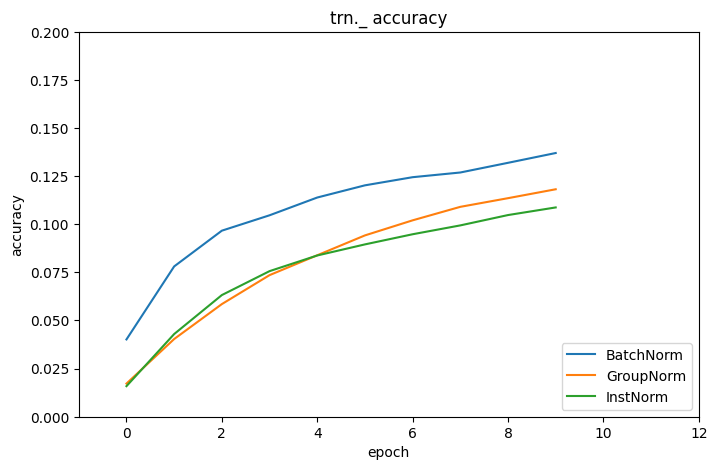

In [49]:
plot_history(hists, attribute='accuracy', axis=(-1,12,0,0.2), loc='lower right')

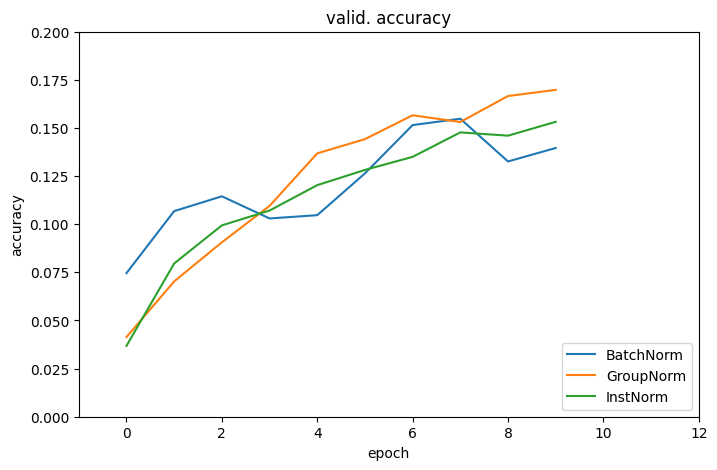

In [48]:
plot_history(hists, attribute='val_accuracy', axis=(-1,12,0,0.2), loc='lower right')

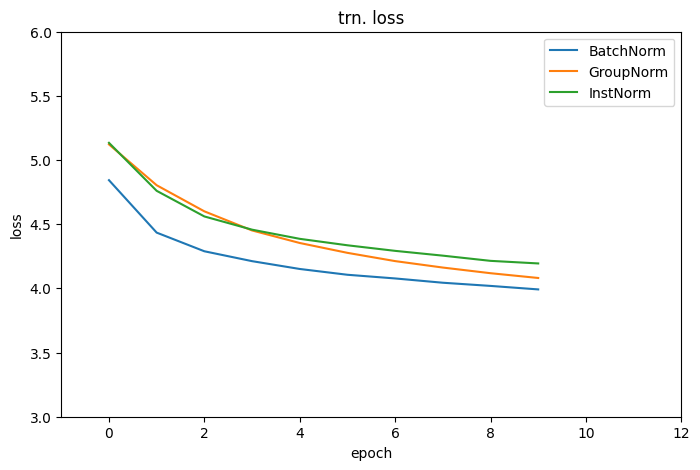

In [54]:
plot_history(hists, attribute='loss', axis=(-1,12,3,6), loc='upper right')

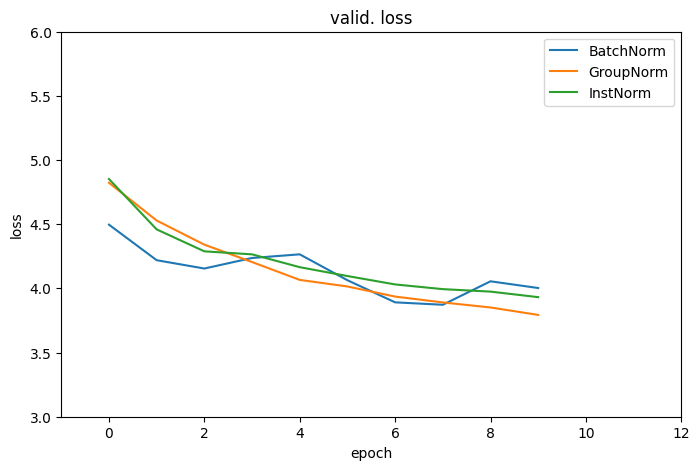

In [55]:
plot_history(hists, attribute='val_loss', axis=(-1,12,3,6), loc='upper right')